In the study "Good debt or bad debt: Detecting semantic orientations in economic texts" by Malo, Pekka, et al., the authors address the challenge of sentiment analysis in the field of economics. Specifically, they aim to determine the semantic orientations of economic texts in order to better understand opinions and attitudes towards debt.

Determining the semantic orientations of economic texts is essential to understanding opinions and attitudes towards debt for several reasons:

- Informing decision-making: Economic texts often influence the decision-making processes of various stakeholders, including investors, policymakers, and businesses. Understanding the sentiment towards debt can help them make better-informed decisions in areas such as investment, risk management, and economic policy.

- Market sentiment: In financial markets, sentiment plays a crucial role in driving asset prices and trends. By analyzing the sentiment in economic texts, market participants can gain insights into prevailing attitudes towards debt, which may influence market behavior and inform investment strategies.

- Economic stability: Excessive levels of debt can pose risks to economic stability. By monitoring the sentiment around debt, policymakers can detect early warning signs of potential imbalances and address them proactively to maintain economic stability and growth.

- Policy effectiveness: Understanding the sentiment towards debt can help policymakers assess the effectiveness of their policies and public communication efforts. For instance, if a policy aimed at reducing debt is met with negative sentiment, policymakers may need to reconsider their approach or improve their communication to gain public support.

- Public opinion: Sentiment analysis of economic texts can help capture public opinion and identify trends in attitudes towards debt. This information can be valuable for governments, central banks, and other institutions in shaping their policies and understanding the potential impact on the broader population.


In [43]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

import random

random.seed(42)
np.random.seed(42)

from sklearn.model_selection import train_test_split
sns.set(style='whitegrid', palette='cubehelix')
from sklearn.metrics import accuracy_score

In [44]:
prefix_path = "/kaggle/input/financial-sentiment-analysis"

In [45]:
df = pd.read_csv(os.path.join(prefix_path, "data.csv"))

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

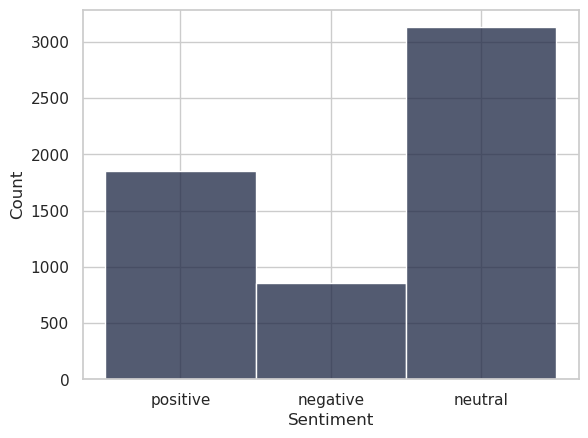

In [46]:
sns.histplot(x = "Sentiment",data = df)

In [47]:
df.shape

(5842, 2)

In [48]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [49]:
X = df.drop(columns = ["Sentiment"])
y = df[["Sentiment"]]

In [50]:
binarizer = LabelBinarizer()
y = binarizer.fit_transform(y.values)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [52]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [53]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [54]:
text_test = X_train.values[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  6983 20962  1011  2241  4475  9338 18347 15687 13058  1006  2002]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [55]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [56]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape = (),dtype = tf.string,name = "text")
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess,name = "preprocessing")
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder,trainable = True,name = "BERT_encoder")
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(3, activation = "softmax",name = "classifier")(net)
    return tf.keras.Model(text_input,net)

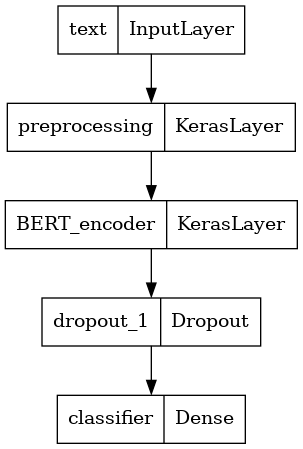

In [57]:
model = build_classifier_model()
tf.keras.utils.plot_model(model)

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(
    optimizer = optimizer,
    loss = "categorical_crossentropy",
    metrics = "accuracy"
) 

In [60]:
from keras.callbacks import EarlyStopping
call_back = EarlyStopping(monitor = "val_loss",patience = 4);

In [61]:
print(f"Training model : {tfhub_handle_encoder}")
history = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val,y_val),
    epochs = 5,
    batch_size = 128,
    callbacks = [call_back]
)

Training model : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2
Epoch 1/5
28/28 [==============================] - 1568s 54s/step - loss: 0.8850 - accuracy: 0.6067 - val_loss: 0.5173 - val_accuracy: 0.7613
Epoch 2/5
28/28 [==============================] - 1513s 54s/step - loss: 0.5043 - accuracy: 0.7788 - val_loss: 0.5554 - val_accuracy: 0.7707
Epoch 3/5
28/28 [==============================] - 1521s 55s/step - loss: 0.3917 - accuracy: 0.8256 - val_loss: 0.7074 - val_accuracy: 0.6792
Epoch 4/5
28/28 [==============================] - 1501s 54s/step - loss: 0.5133 - accuracy: 0.7862 - val_loss: 0.6595 - val_accuracy: 0.7639
Epoch 5/5
28/28 [==============================] - 1500s 54s/step - loss: 0.2961 - accuracy: 0.8662 - val_loss: 0.6514 - val_accuracy: 0.7707


In [62]:
loss, accuracy = model.evaluate(X_test,y_test)
print(f"Loss : {loss} , acc : {accuracy}")

37/37 [==============================] - 143s 4s/step - loss: 0.6961 - accuracy: 0.7673
Loss : 0.6961158514022827 , acc : 0.7673224806785583


In [63]:
y_pred = model.predict(X_test)

37/37 [==============================] - 122s 3s/step


In [64]:
y_pred = np.argmax(y_pred, axis = 1)

In [65]:
classes = binarizer.classes_

In [71]:
y_true = []
for i in range(len(y_pred)):
    real = np.argmax(y_test[i])
    y_true.append(real)

In [72]:
cmp = pd.DataFrame(dict(y_true=[classes[e] for e in y_true], y_pred=[classes[e] for e in y_pred]))

In [73]:
cmp.head()

,y_true,y_pred
0,neutral,neutral
1,positive,positive
2,negative,negative
3,positive,positive
4,neutral,neutral


In [69]:
model.save("financial_sentiment_BERT")

In [70]:
accuracy_score(y_true, y_pred)

0.76732249786142